# Deploy ControlNet for Stable Diffusion on a SageMaker GPU Multi-Model Endpoint with Triton

This notebook will guide you through text-to-image generation with various ControlNet Techniques with Stable Diffussion on a SageMaker Multi-Model GPU Endpoint powered by NVIDIA Triton Inference Server 

This notebook was tested succesfully in the `us-east-1` AWS region on the `Data Science` SageMaker Studio image

> ⚠ **Warning**: This notebook requires a minimum of an `ml.m5.large` instance to build the conda environment required for hosting the Stable Diffusion models.

#### Step 1: SetUp

In [10]:
!pip install -U sagemaker pillow huggingface-hub
!conda install ctools/label/dev::conda-pack -y
import os
import shutil
from distutils.dir_util import copy_tree
from pathlib import Path
import sagemaker
from huggingface_hub import snapshot_download
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.s3 import S3Uploader
bucket_name='[BUCKET NAME]'
sess = sagemaker.Session(default_bucket=bucket_name)
role = sagemaker.get_execution_role()
bucket=sess.default_bucket()
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import json
import boto3

#### Step 2: Download model weights to local dir

Download all models (Stable Diffusion 1.5 and all ControlNet techniques) from HuggingFace Hub to local directory. Once downloaded we compress these models to a `tar.gz` format (which is required by sagemaker hosting) together with their respective inference logic and additional files needed by the Nvidia Triton server

In [ ]:
os.makedirs('mme/models/',exist_ok=True)
model_id = ["lllyasviel/sd-controlnet-canny","lllyasviel/sd-controlnet-depth","lllyasviel/sd-controlnet-hed",
             "lllyasviel/sd-controlnet-mlsd","lllyasviel/sd-controlnet-openpose","lllyasviel/sd-controlnet-scribble",
           "runwayml/stable-diffusion-v1-5"]
for ids in model_id:
    # Create local dir to download models into
    path_dir=f"mme/models/{ids.split('-',2)[-1]}/{ids.split('-',2)[-1]}/1/{ids.split('-',2)[-1]}"
    model_tar_dir = Path(path_dir)
    if model_tar_dir.exists():        
        shutil.rmtree(str(model_tar_dir))
    os.makedirs(path_dir,exist_ok=True)

    
    # unwanted checkpoint files in sdv1.5 to reduce weight of model
    unwanted_files_sd=["v1-5-pruned-emaonly.safetensors","*ckpt","v1-5-pruned.safetensors","v1-inference.yaml"]

    if ids =="runwayml/stable-diffusion-v1-5":
        snapshot_download(ids, local_dir=str(model_tar_dir), local_dir_use_symlinks=False,ignore_patterns=unwanted_files_sd)
    else:
        snapshot_download(ids, local_dir=str(model_tar_dir), local_dir_use_symlinks=False)  

#### Step 3: Packaging a Conda environment for all dependencies

Creating a conda enviroment with all dependencies needed by the different techniques of ControlNet and Stable Diffusion models. This environment will be shared by all ControlNet techniques. However, there are multpile way to install dependencies, this way helps to reduce size requiremnets.
However, this approach is limited to a single instance deployment only, there is no guarantee this will work for a multi instance deployment.

Write all the modules to intsall to a yaml file

In [8]:
%%writefile mme/environment.yml
name: mme_env
dependencies:
  - python=3.8
  - pip
  - pip:
      - numpy      
      - diffusers
      - accelerate
      - opencv-contrib-python-headless
      - controlnet-aux
      - xformers      
      - opencv-python-headless
      - transformers
      - torch --extra-index-url https://download.pytorch.org/whl/cu118
      - boto3  
      - conda-pack
    

Overwriting mme/environment.yml


#### Step 4: Prepare the Conda Environment for our dependencies

Create a conda environment from the above yaml file

In [ ]:
!conda env create -f mme/environment.yml

Package the conda environment to a tar.gz file a store locally. This file would later be uploaded to S3.

In [12]:
os.makedirs('mme/models/setup_conda/setup_conda/',exist_ok=True)
!conda pack -n mme_env -o mme/models/setup_conda/setup_conda/sd_env.tar.gz

Packing environment at '/opt/conda/envs/mme_env' to 'mme/models/setup_conda/setup_conda/sd_env.tar.gz'
[########################################] | 100% Completed |  3min 49.3s


We point to this compressed conda environment with all our dependencies (`sd_env.tar.gz`) in the config.pbtxt file of the models that should use it, adding the snippet:
```json
parameters: {
  key: "EXECUTION_ENV_PATH",
  value: {string_value: "path_to_your_env.tar.gz"}
}
```
This files are located within the script directory for each ControlNet Technique. 

#### Step 4: Compress all model artifacts to a `tar.gz` format 

Compressing all model technique with their respective inference script, Triton config file and model weights, then uploading to s3

Nvidia Triton backend requires a [model repository layout](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md) containing the models we want to serve.
This model repository structure for these models is as follows:
```yaml
model-name
     |------ config.pbtxt
     |------ 1
         |------- folder containing ControlNet Technique weights
         |------- folder containing Stable Diffusion model weights
         |------- model.py
```
You can learn more on the structure of the [config.pbtxt file](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_configuration.md)

In [15]:
shutil.rmtree('mme/models/.ipynb_checkpoints',ignore_errors=True)
models=os.listdir('mme/models')

This takes about 1hr plus to complete 

In [ ]:
%%time
import tarfile
import os
for model in models:
    if model =='setup_conda':
        shutil.rmtree(f"mme/models/{model}/.ipynb_checkpoints",ignore_errors=True)
        name=model        
        tar = tarfile.open(f"mme/models/{name}/{name}.tar.gz", "w:gz",compresslevel=2)
        tar.add(f"mme/models/{name}/",arcname='')
        tar.add(f"mme/scripts/{name}/config.pbtxt",arcname=f'{name}/config.pbtxt')
        tar.add(f"mme/scripts/{name}/model.py",arcname=f'{name}/1/model.py')
        tar.close()
    elif model!='v1-5':
        shutil.rmtree(f"mme/models/{model}/.ipynb_checkpoints",ignore_errors=True)
        name=model        
        tar = tarfile.open(f"mme/models/{name}/{name}.tar.gz", "w:gz",compresslevel=2)
        tar.add(f"mme/models/{name}/",arcname='')
        tar.add(f"mme/models/v1-5/v1-5/1/",arcname=f'{name}/1/')
        tar.add(f"mme/scripts/{name}/config.pbtxt",arcname=f'{name}/config.pbtxt')
        tar.add(f"mme/scripts/{name}/model.py",arcname=f'{name}/1/model.py')
        tar.close()
    model_s3_uri=f"s3://{bucket}/mme_controlnet/{name}.tar.gz"
    !aws s3 cp mme/models/{name}/{name}.tar.gz {model_s3_uri}
    !rm mme/models/{name}/{name}.tar.gz

A display of the Canny technique inference script is shown below, same format for other techniques. Here we follow the [python_backend](https://github.com/triton-inference-server/python_backend) format for the triton inference server and write our custom logic for loading model in `initialize(self, args)` function and processing inference in the `execute(self, requests)` function.

In [381]:
!pygmentize -g mme/scripts/canny/model.py

import cv2
import numpy as np
from PIL import Image
import torch
import json
import os
import io
import base64
from io import BytesIO
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DPMSolverMultistepScheduler, UniPCMultistepScheduler
import boto3
from pathlib import Path
import triton_python_backend_utils as pb_utils
from io import BytesIO
import base64

def get_s3_file(bucket, key):
    s3=boto3.client('s3')
    obj=s3.get_object(
        Bucket=bucket,  
        Key=key,    
    )
    image=obj['Body'].read()
    return image

def put_s3_file(bucket,key,image):
    s3=boto3.client('s3')
    s3.put_object(
        Body=image,
        Bucket=bucket,    
        Key=key   
    )

def _encode(image):
    img = image
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()    
    return img_byte_arr

def _decode(image):    
    image=Image.open(io.BytesIO(image))
    return image


# inference functions

#### Step 5: Deployment

Getting the uri for the SageMaker Triton Conatiner Image.

In [14]:
import boto3
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}


region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
mme_triton_image_uri = (
    "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:22.12-py3".format(
        account_id=account_id_map[region], region=region, base=base
    )
)

Configuring the multi-model gpu endpoint

In [21]:
import time
model_data_url = f"s3://{bucket}/mme_controlnet/"  # s3 location where models are stored
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
}

In [ ]:
sm_model_name = f"mme-mdl-controlnet-{ts}"
sm_client=boto3.client('sagemaker')
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Creating a SageMaker enpoint configuration 

In [ ]:
endpoint_config_name = f"mme-mdl-controlnet-{ts}"
instance_type = "ml.g5.4xlarge"

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Deploying and waiting for endpoint to be in `InService` status

In [ ]:
endpoint_name = f"mme-mdl-controlnet-{ts}"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

In [ ]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(30)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

You can list the S3 bucket to see all the compressed model artifacts stored. This will be the location the endpoint would pull models from when you specify a target model In the Sahemaker InvokeEnpoint api call

In [ ]:
!aws s3 ls s3://{bucket}/mme_controlnet/

#### Step 6: Query the Models

We first need to invoke the setup_conda artifact to copy all the conda environment into a directory that can be shared by all ControlNet models

In [33]:
# invoke the setup_conda model to create the shared conda environment
runtime_sm_client=boto3.client('sagemaker-runtime')
import json
payload = {
    "inputs": [
        {
            "name": "TEXT",
            "shape": [1],
            "datatype": "BYTES",
            "data": ["hello"],  # dummy data not used by the model
        }
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="setup_conda.tar.gz",
)

Prompt used to invoke the different ControlNet models. The input image is stored in S3

In [44]:
p_p="metal orange colored car, complete car, colour photo, outdoors in a pleasant landscape, realistic, high quality"
n_p="cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, blurry, bad anatomy, bad proportions"

request={"prompt":p_p,
         "negative_prompt":n_p,
         "image_uri":'[LOCATION OF IMAGE IN S3]',
         "scale": 0.5,
         "steps":20,
         "low_threshold":100,
         "high_threshold":200,
         "seed": 12345,
         "output":"output"
        }

## CANNY

In [45]:

inputs = dict(   
    input_payload=json.dumps(request),
)

#payload must be in the structure specified in the config.pbtxt file
payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}
mode='canny'
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel=f"{mode}.tar.gz", # specify the target model to run inference on
    Accept="application/json"
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"] 

Downloading the outputs from S3

In [46]:
!aws s3api get-object --bucket {bucket} --key {request['output']}/{output[0]["data"][0].split('/',4)[-1]} {mode}.png
!aws s3api get-object --bucket {bucket} --key {request['output']}/{mode}_{output[0]["data"][0].split('/',4)[-1]} {mode}_{mode}.png

{
    "AcceptRanges": "bytes",
    "LastModified": "Tue, 27 Jun 2023 14:32:34 GMT",
    "ContentLength": 1032824,
    "ETag": "\"1041c11ee8152474492bb90ec2845669\"",
    "ContentType": "binary/octet-stream",
    "ServerSideEncryption": "AES256",
    "Metadata": {}
}
{
    "AcceptRanges": "bytes",
    "LastModified": "Tue, 27 Jun 2023 14:32:34 GMT",
    "ContentLength": 14972,
    "ETag": "\"162451ec8b1af7256fc89cd803052d2d\"",
    "ContentType": "binary/octet-stream",
    "ServerSideEncryption": "AES256",
    "Metadata": {}
}


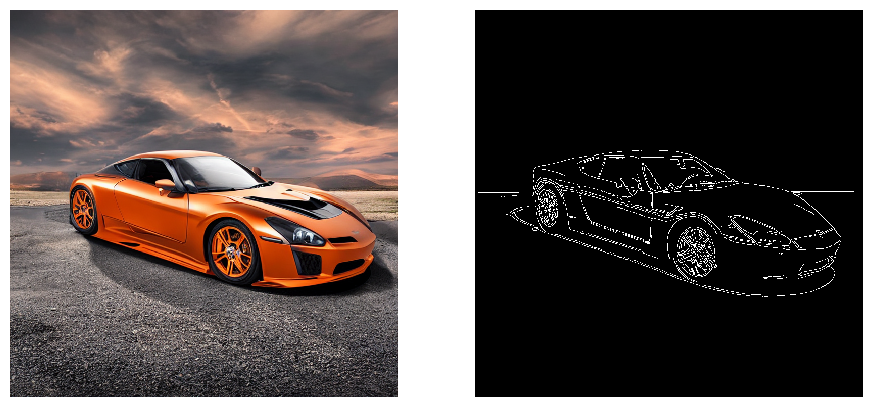

In [47]:
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8
image = Image.open(f'{mode}.png')
image_canny=Image.open(f'canny_{mode}.png')
fig, ax = plt.subplots(1,2)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(image)
ax[1].imshow(image_canny)


## DEPTH

In [64]:
p_p="metal red colored car, complete car, colourphoto, outdoors in pleasant landscape onbeach, realistic, high quality"
request["prompt"]=p_p
request["seed"]=342
inputs = dict(   
    input_payload=json.dumps(request),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}
mode='depth'
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel=f"{mode}.tar.gz",
    Accept="application/json"
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]

In [65]:
!aws s3api get-object --bucket {bucket} --key {request['output']}/{output[0]["data"][0].split('/',4)[-1]} {mode}.png
!aws s3api get-object --bucket {bucket} --key {request['output']}/{mode}_{output[0]["data"][0].split('/',4)[-1]} {mode}_{mode}.png

{
    "AcceptRanges": "bytes",
    "LastModified": "Tue, 27 Jun 2023 15:01:00 GMT",
    "ContentLength": 1150492,
    "ETag": "\"265147dd07614f8674fedbb69511d243\"",
    "ContentType": "binary/octet-stream",
    "ServerSideEncryption": "AES256",
    "Metadata": {}
}
{
    "AcceptRanges": "bytes",
    "LastModified": "Tue, 27 Jun 2023 15:01:00 GMT",
    "ContentLength": 50781,
    "ETag": "\"65c465695e93dfc2eb181c38ef60aab4\"",
    "ContentType": "binary/octet-stream",
    "ServerSideEncryption": "AES256",
    "Metadata": {}
}


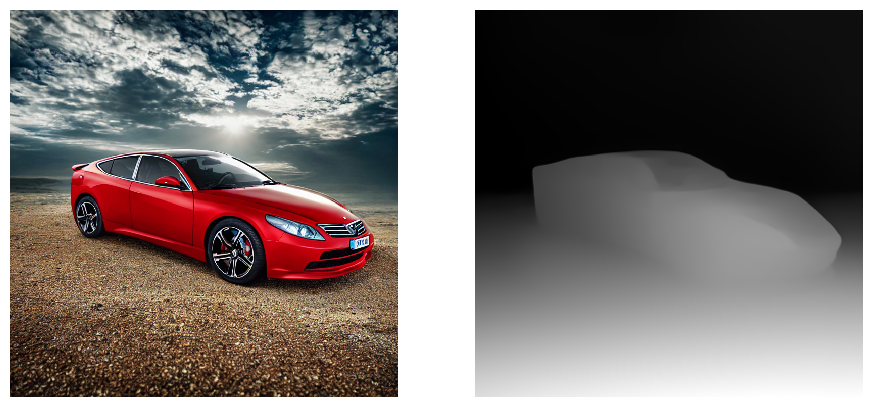

In [66]:
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8
image = Image.open(f'{mode}.png')
image_canny=Image.open(f'{mode}_{mode}.png')
fig, ax = plt.subplots(1,2)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(image)
ax[1].imshow(image_canny)

## HED

In [55]:
p_p="metal white colored car, complete car,colour photo, in a city, at night, realistic,high quality"
request["prompt"]=p_p
request["seed"]=125

inputs = dict(   
    input_payload=json.dumps(request),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}
mode='hed'
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel=f"{mode}.tar.gz",
    Accept="application/json"
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]

In [56]:
!aws s3api get-object --bucket {bucket} --key {request['output']}/{output[0]["data"][0].split('/',4)[-1]} {mode}.png
!aws s3api get-object --bucket {bucket} --key {request['output']}/{mode}_{output[0]["data"][0].split('/',4)[-1]} {mode}_{mode}.png

{
    "AcceptRanges": "bytes",
    "LastModified": "Tue, 27 Jun 2023 14:58:57 GMT",
    "ContentLength": 433148,
    "ETag": "\"06b4c022d3d41cf6cf6badc17c6bbf7b\"",
    "ContentType": "binary/octet-stream",
    "ServerSideEncryption": "AES256",
    "Metadata": {}
}
{
    "AcceptRanges": "bytes",
    "LastModified": "Tue, 27 Jun 2023 14:58:57 GMT",
    "ContentLength": 75586,
    "ETag": "\"b59a3860857d04a53df2c1e6f0992607\"",
    "ContentType": "binary/octet-stream",
    "ServerSideEncryption": "AES256",
    "Metadata": {}
}


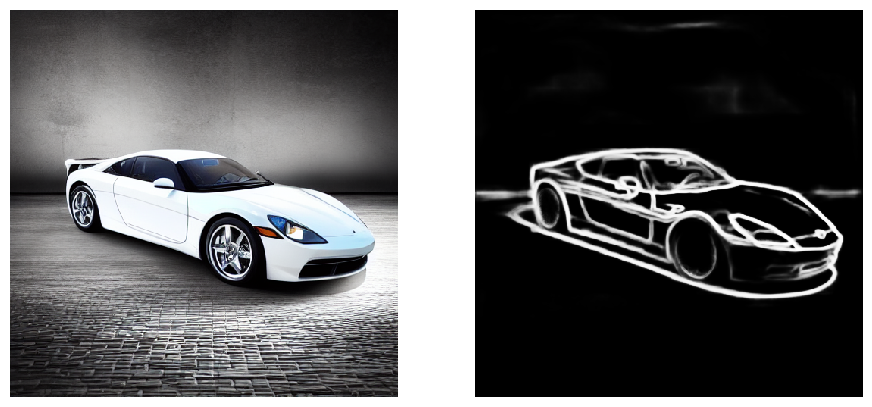

In [57]:
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8
image = Image.open(f'{mode}.png')
image_hed=Image.open(f'{mode}_{mode}.png')
fig, ax = plt.subplots(1,2)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(image)
ax[1].imshow(image_hed)


## MLSD

In [361]:
inputs = dict(   
    input_payload=json.dumps(request),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}
mode='mlsd'
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel=f"{mode}.tar.gz",
    Accept="application/json"
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]

In [ ]:
!aws s3api get-object --bucket {bucket} --key {request['output']}/{output[0]["data"][0].split('/',4)[-1]} {mode}.png
!aws s3api get-object --bucket {bucket} --key {request['output']}/{mode}_{output[0]["data"][0].split('/',4)[-1]} {mode}_{mode}.png

In [ ]:
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8
image = Image.open(f'{mode}.png')
image_mlsd=Image.open(f'{mode}_{mode}.png')
fig, ax = plt.subplots(1,2)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(image)
ax[1].imshow(image_mlsd)

## OPENPOSE

In [364]:
inputs = dict(   
    input_payload=json.dumps(request),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}
mode='openpose'
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel=f"{mode}.tar.gz",
    Accept="application/json"
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]

In [ ]:
!aws s3api get-object --bucket {bucket} --key {request['output']}/{output[0]["data"][0].split('/',4)[-1]} {mode}.png
!aws s3api get-object --bucket {bucket} --key {request['output']}/{mode}_{output[0]["data"][0].split('/',4)[-1]} {mode}_{mode}.png

In [ ]:
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8
image = Image.open(f'{mode}.png')
image_openpose=Image.open(f'{mode}_{mode}.png')
fig, ax = plt.subplots(1,2)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(image)
ax[1].imshow(image_openpose)


## SCRIBBLE

In [70]:
p_p="metal blue colored car, similar to originalcar, complete car, colour photo, outdoors,breath-taking view, realistic, high quality,different viepoint"
request["prompt"]=p_p
request["seed"]=512
inputs = dict(   
    input_payload=json.dumps(request),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}
mode='scribble'
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel=f"{mode}.tar.gz",
    Accept="application/json"
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]

In [71]:
!aws s3api get-object --bucket {bucket} --key {request['output']}/{output[0]["data"][0].split('/',4)[-1]} {mode}.png
!aws s3api get-object --bucket {bucket} --key {request['output']}/{mode}_{output[0]["data"][0].split('/',4)[-1]} {mode}_{mode}.png

{
    "AcceptRanges": "bytes",
    "LastModified": "Tue, 27 Jun 2023 15:05:17 GMT",
    "ContentLength": 460778,
    "ETag": "\"b08acf1d73330c9e2f6450a78d06908a\"",
    "ContentType": "binary/octet-stream",
    "ServerSideEncryption": "AES256",
    "Metadata": {}
}
{
    "AcceptRanges": "bytes",
    "LastModified": "Tue, 27 Jun 2023 15:05:17 GMT",
    "ContentLength": 4802,
    "ETag": "\"c1e5a491dfa894857c2707105b7aac09\"",
    "ContentType": "binary/octet-stream",
    "ServerSideEncryption": "AES256",
    "Metadata": {}
}


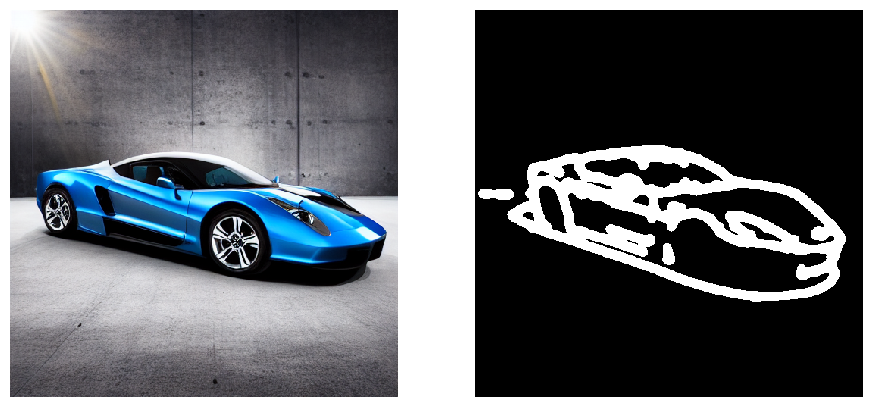

In [75]:
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8
image = Image.open(f'{mode}.png')
image_scribble=Image.open(f'{mode}_{mode}.png')
fig, ax = plt.subplots(1,2)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(image)
ax[1].imshow(image_scribble)

#### Clean up

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=sm_model_name)

In [ ]:
#delete models in respective paths
!rm -rf mme/models